let's create a nerual network without specialized libraries

In [1]:
import numpy as np

steps:

create layers,
create weights and biases,
create loss function,
create forwards,
    including squoosh
create backprop,
    create gradient descent!

create all of the above without regard for crossing all training examples, handle that later


In [2]:
# create layers and weights
picture_size = 28 * 28
input_size = picture_size
output_size = 10
fc_layer_size = 16

inlayer = np.zeros(shape=(1,input_size), dtype=np.float32) 
layer1 = np.zeros(shape=(1,fc_layer_size), dtype=np.float32)
layer2 = np.zeros(shape=(1,fc_layer_size), dtype=np.float32)
layer3 = np.zeros(shape=(1,fc_layer_size), dtype=np.float32)
outlayer = np.zeros(shape=(1,output_size), dtype=np.float32)

layer1_wieghts = np.zeros(shape=(input_size,fc_layer_size), dtype=np.float32) #adding 1 for the bias
layer2_wieghts = np.zeros(shape=(fc_layer_size,fc_layer_size), dtype=np.float32)
layer3_wieghts = np.zeros(shape=(fc_layer_size,fc_layer_size), dtype=np.float32)
outlayer_wieghts = np.zeros(shape=(fc_layer_size,output_size), dtype=np.float32)

#inlayer = np.random.rand(1,input_size)
layer1_wieghts = np.random.rand(input_size,fc_layer_size) #adding 1 for the bias
layer2_wieghts = np.random.rand(fc_layer_size,fc_layer_size)
layer3_wieghts = np.random.rand(fc_layer_size,fc_layer_size)
outlayer_wieghts = np.random.rand(fc_layer_size,output_size)

#inlayer[0,:] = [0,1,2,3,4]
#layer1_wieghts[0,:] = [0,1,0,0.25,-1]
#layer1_wieghts[:,0] = [0,1,0.5,0,-1]

learning_rate = 0.1


In [3]:
#mathy bits
import math

def sigx(number):
    try:
        sig_x = ( 1 / (1+ math.exp(-number)))
        #this does not woprk for large negitive numbers 
        # due to rounding errors leading to devide by zero so we'll add error handling
    except OverflowError:
        sig_x = 0
    return(sig_x)

def label_to_output(int):
    outlayer = np.zeros(shape=(1,output_size), dtype=np.float32)
    outlayer[0,int] = 1
    return(outlayer)

def single_layer_node_val(node_location, prior_layer, wieghts):
    #n_v = sigx of weights and biases of previous layer
    node_vl = 0
    for index, node in enumerate(prior_layer[0,:]):
        node_vl = node_vl + node * wieghts[index , node_location]
    node_vl = sigx(node_vl/prior_layer.size)   
    return(node_vl)

def find_layer_node_vals(prior_layer, target_layer, weights):
    tar_layer = np.zeros_like(target_layer)
    for index, node in enumerate(tar_layer[0,:]):
        tar_layer[0,index] = single_layer_node_val(index, prior_layer=prior_layer, wieghts=weights)
        #print("index location", index)
    return tar_layer


def find_loss_single(out_layer, expected_out):
    node_loss = np.zeros(output_size, dtype=np.float32)
    for index, value in enumerate(out_layer[0,:]):
        node_loss[index] = (out_layer[0,index] - expected_out[0,index]) ** 2
        #print("index:", index)
        #print("output value: ", out_layer[0,index])
        #print("expected value: ", expected_out[0,index])
        #print("node loss:", index, node_loss[index])
    MSE = np.sum(node_loss)/output_size
    #RMSE = math.sqrt(MSE)
    return(MSE)

def backprop_single_layer(target_layer, prior_layer, desired_target_layer, weights):

    current_A_delta = desired_target_layer - target_layer
    A_delta = np.zeros_like(weights)
    W_delta = np.zeros_like(weights)

    for j, activation in enumerate(target_layer[0,:]):
        for i, weight in enumerate(weights[j,:]):
            W_delta[j, i] = current_A_delta[0,j] * prior_layer[0,i] * learning_rate
            A_delta[j,i]  = current_A_delta[0,j] * weights[j,i] * learning_rate
    
    desired_prior_layer = np.zeros_like(prior_layer)
    for i, neuron in enumerate(desired_prior_layer):
        desired_prior_layer[0,i] = np.mean(A_delta[:,i])

    return(W_delta, desired_prior_layer)


In [4]:
print(label_to_output(2))

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
def forwards(input_layer, layer1_wieghts, layer2_wieghts, layer3_wieghts, outlayer_wieghts):
    layer1[0,:] = find_layer_node_vals(input_layer, layer1, layer1_wieghts)
    layer2[0,:] = find_layer_node_vals(layer1, layer2, layer2_wieghts)
    layer3[0,:] = find_layer_node_vals(layer2, layer3, layer3_wieghts)
    outlayer[0,:] = find_layer_node_vals(layer3, outlayer, outlayer_wieghts)
    return(outlayer)

# back propigate
def backprop(outlayer, outlayer_key):
    w_delta_out, desired_prior_layer3 = backprop_single_layer(outlayer, layer3, outlayer_key, outlayer_wieghts)
    w_delta_3, desired_prior_layer2 = backprop_single_layer(layer3, layer2, desired_prior_layer3, layer3_wieghts) # not sure if I should backprop the weight changes somehow too?
    w_delta_2, desired_prior_layer1 = backprop_single_layer(layer2, layer1, desired_prior_layer2, layer2_wieghts)
    w_delta_1, desired_prior_layer0 = backprop_single_layer(layer1, inlayer, desired_prior_layer1, layer1_wieghts)
    w_deltas = [w_delta_1, w_delta_2, w_delta_3, w_delta_out]
    return(w_deltas)


In [6]:
import matplotlib.pyplot as plt


image_size = 28
batch_size = 100
num_train_images = 60000

num_batchs = num_train_images/batch_size
epochs = 2
loss_over_time = np.zeros([int(num_batchs)*epochs])


for epoch in range(0,epochs,1):
    print("epoch ", int(epoch), "out of ", int(epochs))
    f = open("MNIST/train-images.idx3-ubyte", 'rb')
    f.read(16)
    l = open("MNIST/train-labels.idx1-ubyte",'rb')
    l.read(8)

    for i in range(0,num_train_images,batch_size):
        print("batch ", int(i/batch_size), "out of ", int(num_batchs))
        image_buffer = f.read(image_size * image_size * batch_size)
        batch = np.frombuffer(image_buffer, dtype=np.uint8).astype(np.float32)
        batch = batch.reshape(batch_size, (image_size**2))

        label_buffer = l.read(batch_size)
        label_batch = np.frombuffer(label_buffer, dtype=np.uint8).astype(np.int64)


        # batch is a batch_size by 784 float32 array
        w_1_d = np.zeros((batch_size, input_size, fc_layer_size))
        w_2_d = np.zeros((batch_size, fc_layer_size, fc_layer_size))
        w_3_d = np.zeros((batch_size, fc_layer_size, fc_layer_size))
        w_out_d = np.zeros((batch_size, fc_layer_size, output_size))
        loss_arr = np.zeros(batch_size)

        for index, image in enumerate(batch):
            inlayer[0,:] = image/255
            outlayer = forwards(inlayer, layer1_wieghts, layer2_wieghts, layer3_wieghts, outlayer_wieghts)
            outlayer_key = label_to_output(label_batch[index])
            w_1_d[index,:], w_2_d[index,:], w_3_d[index,:], w_out_d[index,:] = backprop(outlayer, outlayer_key)
            loss_arr[index] = find_loss_single(outlayer, outlayer_key)
            

        layer1_wieghts = layer1_wieghts + np.mean(w_1_d, axis=(0))
        layer2_wieghts = layer2_wieghts + np.mean(w_2_d, axis=(0))
        layer3_wieghts = layer3_wieghts + np.mean(w_3_d, axis=(0))
        outlayer_wieghts = outlayer_wieghts + np.mean(w_out_d, axis=(0))
        loss = np.mean(loss_arr)
        print(loss)
        loss_over_time[int((i/batch_size))*(epoch+1)] = loss
            



epoch  0 out of  2
batch  0 out of  600
0.31176702946424484
batch  1 out of  600
0.3091222932934761
batch  2 out of  600
0.30650781601667404
batch  3 out of  600
0.3038390776515007
batch  4 out of  600
0.3014554789662361
batch  5 out of  600
0.29908576995134356
batch  6 out of  600
0.2967484176158905
batch  7 out of  600
0.2944777184724808
batch  8 out of  600
0.2921663701534271
batch  9 out of  600
0.29006804317235946
batch  10 out of  600
0.2880067831277847
batch  11 out of  600
0.28605691343545914
batch  12 out of  600
0.28421976625919343
batch  13 out of  600
0.28232431203126906
batch  14 out of  600
0.28063480377197264
batch  15 out of  600
0.2789856189489365
batch  16 out of  600
0.2771051025390625
batch  17 out of  600
0.27547306030988694
batch  18 out of  600
0.2738919773697853
batch  19 out of  600
0.2725008976459503
batch  20 out of  600
0.270531205534935
batch  21 out of  600
0.2691104775667191
batch  22 out of  600
0.26794381111860277
batch  23 out of  600
0.266493806540966

KeyboardInterrupt: 

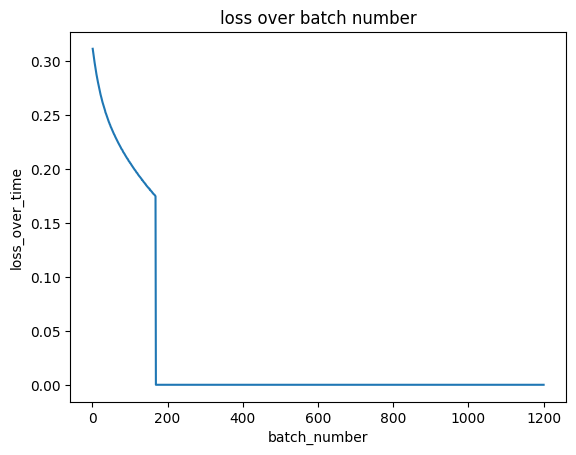

In [7]:
import matplotlib.pyplot as plt
batch_number = np.arange(1, int(num_batchs*epochs + 1))


plt.plot(batch_number,loss_over_time)

plt.xlabel("batch_number")
plt.ylabel("loss_over_time")
plt.title("loss over batch number")
plt.show()


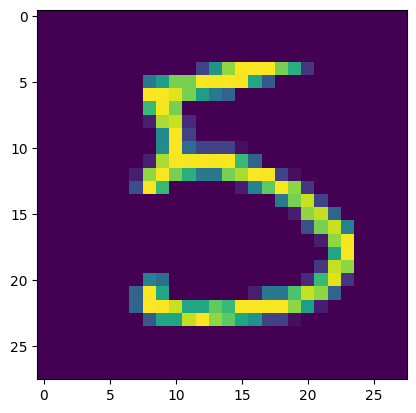

5
[[0.3671598  0.3754369  0.36995852 0.38051555 0.36731708 0.3626232
  0.37177092 0.3820207  0.38160008 0.36494827]]
loss 0.1661551


In [8]:
import numpy as np

f = open("MNIST/t10k-images.idx3-ubyte", 'rb')

image_size = 28
num_images = 50
choice = 15

try:
    f.read(16)
except UnicodeDecodeError as error:
    print(error)
    print("utf-8 error is usally due to binary format")


buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
batch = data.reshape(num_images, picture_size)
data = data.reshape(num_images, image_size, image_size, 1)

import matplotlib.pyplot as plt
image = np.asarray(data[choice]).squeeze()
plt.imshow(image)
plt.show()

l = open("MNIST/t10k-labels.idx1-ubyte",'rb')
l.read(8)
buf = l.read(10000)
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(labels[choice])

inlayer[0,:] = batch[choice]
outlayer = forwards(inlayer, layer1_wieghts, layer2_wieghts, layer3_wieghts, outlayer_wieghts)
print(outlayer)

print("loss", find_loss_single(outlayer, label_to_output(labels[choice])))
